### U-Net Nuclei masks EDA
Part of Kaggle's 2018 Data Sciene Bowl

https://www.kaggle.com/c/data-science-bowl-2018


In [23]:
import os
import sys
import random
import  warnings
import pandas as pd
import numpy  as np
import matplotlib.pyplot  as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import tensorflow as tf

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
TRAIN_PATH = './U_NET/train/'
TEST_PATH = './U_NET/validation/'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
random.seed = 42
np.random.seed = 42



#### Collecting files for our training and test data

In [10]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating the image masks

In [25]:
print("getting and resizing the images ")
x_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, 1), dtype = np.uint8)


# resizing our training images to 128x128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] #it has 4 channels, keep it to 3
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    x_train[n] = img
    mask = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype = np.bool)
    
    # now we take all the masks associated with that image and combine into a single image
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', 
                               preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
        
    y_train[n] = mask
        
        
# get and resize test images
x_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
print("getting and resizing test images...")
sys.stdout.flush()

# here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    x_test[n] = img

print('Done and Dusted!')

getting and resizing the images 


100%|██████████| 670/670 [03:52<00:00,  2.88it/s]

getting and resizing test images...



100%|██████████| 65/65 [00:01<00:00, 44.87it/s]

Done and Dusted!


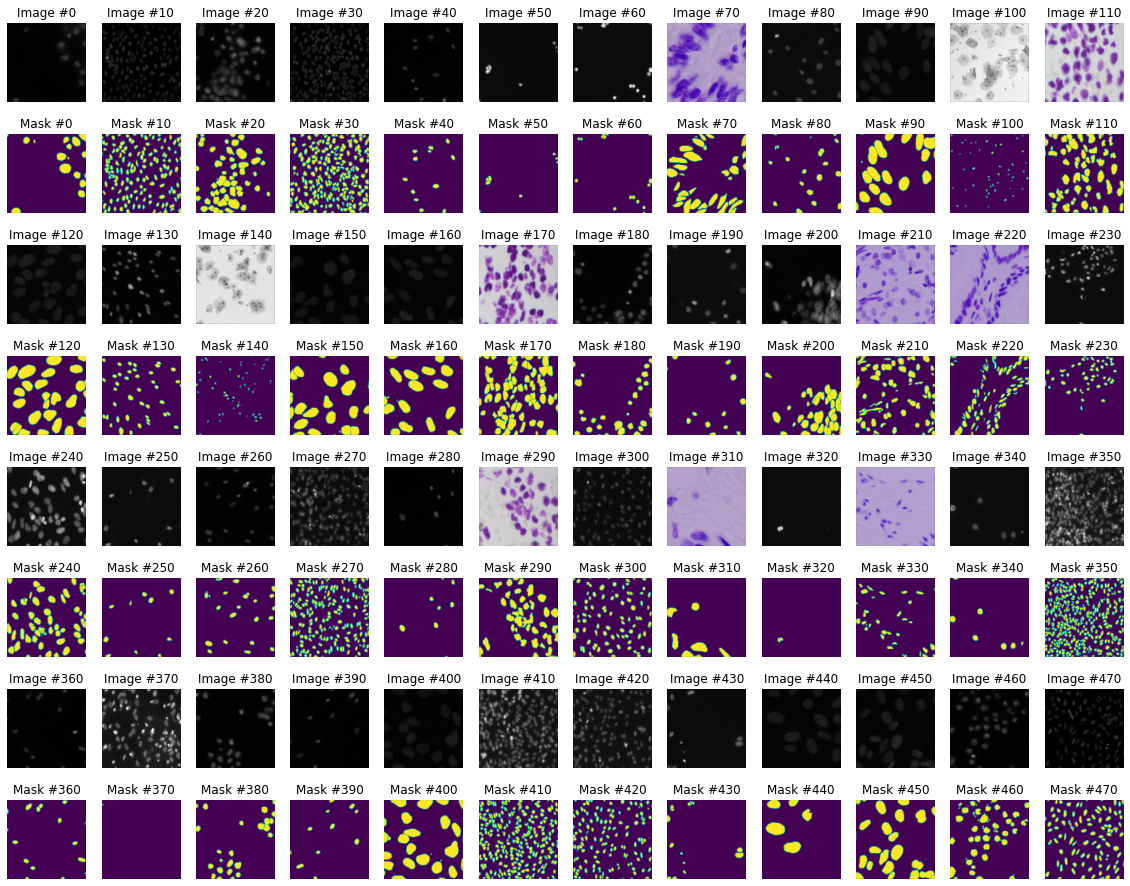

In [29]:
# Damn that took a lot of time!

# Now let's look at how our data looks
plt.figure(figsize=(20,16))
x,y=12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(x_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

### Lets define a custom metric IoU